<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 250px; display: inline"  alt="Wikistat"/></a>

<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" style="float:right; max-width: 250px; display: inline" alt="IMT"/> </a>
</center>

# [Tutoriel d'apprentissage automatique](https://github.com/wikistat/MLTraining)

# *NLP* et Catégorisation de Produits en <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 120px; display: inline" alt="R"/></a> avec <a href="http://scikit-learn.org/stable/#"><img src="http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png" style="max-width: 100px; display: inline" alt="R"/></a>

#### Résumé
Le principal objectif est d'illuster sur des vraies données les processus d'analyse de données textuelles ou de langage naturel (NLP). Plusieurs étapes sont considérées et exécutées dans l'environnement Pyhton avec le slibrairies spécialisées. Nesttoyage des textes, éliminaiton des mots inutiles, racinisation ainsi que la comparaison de différentes stratgies de vectorisation (comptage, TF-IDF, word2vect). A la suite de quoi l'onjectif de classificaiton en catégorie est atteint en comparant deux méthodes: régresison logistique et forêts aléatoires.


## 1 Introduction

Il s'agit d'une version simplifiée du concours proposé par CDiscount et paru sur le site [datascience.net](https://www.datascience.net/fr/challenge) puis Kaggle. Les données d'apprentissage sont accessibles sur demande auprès de CDiscount. Les solutions de l'échantillon test du concours ne sont pas et ne seront pas rendues publiques. Un échantillon test est donc construit pour l'usage de ce tutoriel.  L'objectif est de prévoir la catégorie d'un produit à partir de son descriptif. Seule la catégorie principale (1er niveau) est prédite au lieu des trois niveaux demandés dans le concours. L'objectif est d'illustrer sur un exemple complexe le prétraitement de données textuelles ou de langave naturel (*Natural Language Process - NLP*). La stratégie de sous ou sur échantillonnage des catégories qui permet d'améliorer la prévision n'a pas été mise en oeuvre.
* L'exemple est présenté sur un échantillon réduit d'un million de produits au lieu des 15M initiaux
* L'échantillon réduit peut encore l'être puis séparé en 2 parties: apprentissage et validation. 
* Les données textuelles sont  nettoyées, racinisées, vectorisées avant modélisation.
* Deux modélisations sont estimées: logistique, forêts aléatoires.

## 2 Prise en charge des données
### 2.1 Environnement

In [1]:
#Importation des librairies utilisées
import unicodedata 
import time
import pandas as pd
import numpy as np
import random
import nltk
import collections
import itertools
import warnings

import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("whitegrid")

import sklearn.model_selection as scv

**Attetnion** Si vous utilisez la librairie `nltk` pour la première fois dans votre environnement, il est nécessaire d'exécuter la commande suivante. Cette commande permet de télécharger de nombreux corpus de texte, mais également des informations grammaticales sur différentes langues; information notamment nécessaire à l'étape de racinisation.

In [2]:
# nltk.download()

### 2.2 Lecture des données

* `cdiscount_train`: 1.000.000 de lignes
* `cdisount_test`: 50.000 lignes

Définition d'une fonction permettant de lire le fichier d'apprentissage et de créer aléatoirement deux *data frames  `Pandas`, un pour l'apprentissage, l'autre pour le test. 

In [3]:
def split_dataset(input_path, nb_line, tauxTest):
    data_all = pd.read_csv(input_path,sep=",", nrows=nb_line)
    data_all = data_all.fillna("")
    data_train, data_test = scv.train_test_split(data_all, test_size = tauxTest)
    time_end = time.time()
    return data_train, data_test

La taille du fichier est limité à `nb_line=10 000` pour réduire les temps de calcul à venir. Ce nombre peut être augmenté afin de tester une amélioraiton des performances mais au prix du temps de calcul. Cette analyse systématique de l'impact de la taille de l'échantillon est développé par [Besse et al. (2017)](https://hal.archives-ouvertes.fr/hal-01350099v3) qui opèrent de plus une comparaison des performances entre R, Python et Spark. 

In [4]:
input_path = "data/cdiscount_train.csv.zip"
nb_line=100000  # part totale extraite du fichier initial ici déjà réduit
tauxTest = 0.05 # proportion de l'échantillon test
data_train, data_test = split_dataset(input_path, nb_line, tauxTest)
# Cette ligne permet de visualiser les 5 premières lignes du DataFrame 
N_train = data_train.shape[0]
N_test = data_test.shape[0]
print("Train set : %d elements, Test set : %d elements" %(N_train, N_test))
data_train.head(5)

Train set : 95000 elements, Test set : 5000 elements


,Categorie1,Categorie2,Categorie3,Description,Libelle,Marque
88728,INFORMATIQUE,CONNECTIQUE - ALIMENTATION,BATTERIE,Batterie pour HP PAVILION G6-1201SU - 8800mAh ...,Batterie pour HP PAVILION G6-1201SU - 8800mAh |…,HP
3518,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,HOUSSE - ETUI - CHAUSSETTE,Coque Flip Case Housse Étui Motorola Moto G Ve...,MOONCASE Coque en Cuir Portefeuille Housse de ...,AUCUNE
59217,BIJOUX - LUNETTES - MONTRES,MONTRES,MONTRE BRACELET,Montre Homme Guess Collection GC Slim Class X6...,Montre Homme Guess Collection GC Slim Class X6...,GUESS COLLECTION
10222,CULTURE / JEUX,FILM,DVD,Pack 2 DVD - Georges et Martha : Georges et Ma...,Pack 2 DVD - Georges et Martha,HOBBY TECH
80071,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,FILM DE PROTECTION TELEPHONE,ebestStar® Motorola Moto G Lot x6 Film transpa...,ebestStar® Motorola Moto G Lot x6 Film transpa...,EBESTSTAR


### 2.3 Exploration élémentaire

In [5]:
# Liste des catégories du premier niveau
data_train.groupby("Categorie1").first()[["Description","Marque"]]

,Description,Marque
Categorie1,,
ADULTE - EROTIQUE,Bas Maille Résille Leg Avenue Noir - Bas fine...,LEG AVENUE
ANIMALERIE - NEW,box N 37 de transport pour chien aluminium - L...,AUCUNE
ARME DE COMBAT - ARME DE SPORT,Visée Type RTS Dueck Defense Aluminium - Visée...,DUKE
ART DE LA TABLE - ARTICLES CULINAIRES,Glaçons Piles - Vous souhaitez proposer à vos ...,MUSTARD
ARTICLES POUR FUMEUR,E-liquide D'Lice Tabac Corse 18 mg - E-liquide...,D'LICE
AUTO - MOTO (NEW),Sortie Echappement Ronde Universelle -Inox- In...,AUCUNE
BAGAGERIE,"ASSASSIN'S CREED - Sac Besace ""Crest"" Petit Fo...",ABY STYLE
BATEAU MOTEUR - VOILIER,Bobinot garcette MS356 Modele 2 mm (x20m) Coul...,AUCUNE
BIJOUX - LUNETTES - MONTRES,Montre Homme Guess Collection GC Slim Class X6...,GUESS COLLECTION


Dénombrement des catégories du premier niveau.

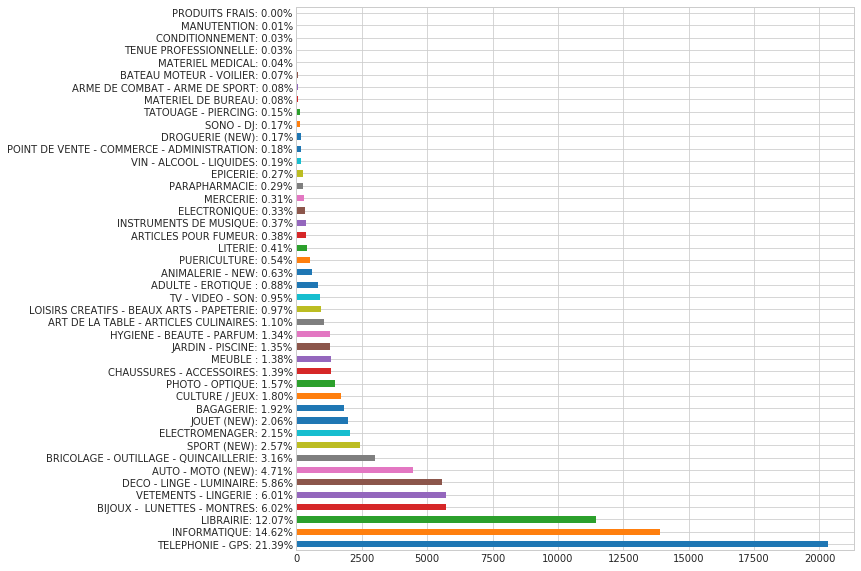

In [6]:
#Count occurence of each Categorie
data_count = data_train["Categorie1"].value_counts()
#Rename index to add percentage
new_index = [k+ ": %.2f%%" %(v*100/N_train) for k,v in data_count.iteritems()]
data_count.index= new_index

fig=plt.figure(figsize= (10,10))
ax = fig.add_subplot(1,1,1)
data_count.plot.barh(logx = False)
plt.show()

Que peut-on dire sur la distribution des ce classes?

Les données sont enregistrées dans les fichiers `train` et `test` de type `csv` pour des réutilisations ultérieures.

In [7]:
data_test.to_csv("data/cdiscount_test.csv", index=False)
data_train.to_csv("data/cdiscount_train_subset.csv", index=False)

##  3. Nettoyage des données
Afin de limiter la dimension de l'espace des variables ou *features*, tout en conservant les informations essentielles, il est nécessaire de nettoyer les données en appliquant plusieurs étapes:
* Chaque mot est écrit en minuscule.
* Les termes numériques, de ponctuation et autres symboles sont supprimés.
* 155 mots-courants, et donc non informatifs, de la langue française sont supprimés (STOPWORDS). Ex: le, la, du, alors, etc...
* Chaque mot est "racinisé", via la fonction `STEMMER.stem` de la librairie nltk. La racinisation transforme un mot en son radical ou sa racine. Par exemple, les mots: cheval, chevaux, chevalier, chevalerie, chevaucher sont tous remplacés par "cheva".

### 3.1 Importation des librairies et fichier pour le nettoyage des données.

In [8]:
# Librairies 
from bs4 import BeautifulSoup #Nettoyage d'HTML
import re # Regex
import nltk # bibliothèque de fonctions NLP

## listes de mots à supprimer dans la description des produits
## Depuis NLTK
nltk_stopwords = nltk.corpus.stopwords.words('french') 
## Depuis Un fichier externe.
lucene_stopwords =open("data/lucene_stopwords.txt","r").read().split(",") #En local
## Union des deux fichiers de stopwords 
stopwords = list(set(nltk_stopwords).union(set(lucene_stopwords)))

## Fonction de stemming ou de racinisation
stemmer=nltk.stem.SnowballStemmer('french')

### 3.2 Illustration sur un descriptif 

**Ligne Originale**

In [9]:
i = 0
description = data_train.Description.values[i]
print("Original Description : " + description)

Original Description : Batterie pour HP PAVILION G6-1201SU - 8800mAh | 10.8V | Li-ion - Batterie pour HP PAVILION G6-1201SU - 8800mAh | 10.8V | Li-ionCaractérist… Voir la présentation


** Supprimer les posibles balises HTML dans la description **

In [10]:
# txt = BeautifulSoup(description,"html.parser",from_encoding='utf-8').get_text()
txt = BeautifulSoup(description,"html.parser").get_text()
print(txt)

Batterie pour HP PAVILION G6-1201SU - 8800mAh | 10.8V | Li-ion - Batterie pour HP PAVILION G6-1201SU - 8800mAh | 10.8V | Li-ionCaractérist… Voir la présentation


** Convertir le texte en minuscule **

In [11]:
txt = txt.lower()
print(txt)

batterie pour hp pavilion g6-1201su - 8800mah | 10.8v | li-ion - batterie pour hp pavilion g6-1201su - 8800mah | 10.8v | li-ioncaractérist… voir la présentation


** Remplacer quelques caractères spéciaux **

* `\u2026`: `…`
* `\u00a0`: `NO-BREAK SPACE`

Cette liste peut être compléter en fonction du jeu de donées étudiés

In [12]:
txt = txt.replace(u'\u2026','.')    
txt = txt.replace(u'\u00a0',' ')
print(txt)

batterie pour hp pavilion g6-1201su - 8800mah | 10.8v | li-ion - batterie pour hp pavilion g6-1201su - 8800mah | 10.8v | li-ioncaractérist. voir la présentation


** Supprimer les accents **

In [13]:
txt = unicodedata.normalize('NFD', txt).encode('ascii', 'ignore').decode("utf-8")
print(txt)

batterie pour hp pavilion g6-1201su - 8800mah | 10.8v | li-ion - batterie pour hp pavilion g6-1201su - 8800mah | 10.8v | li-ioncaracterist. voir la presentation


** Supprimer les caractères qui ne sont ne sont pas des lettres minuscules **

In [14]:
txt = re.sub('[^a-z_]', ' ', txt)
print(txt)

batterie pour hp pavilion g      su       mah       v   li ion   batterie pour hp pavilion g      su       mah       v   li ioncaracterist  voir la presentation


** Remplacer la description par une liste de mots (tokens), supprimer les mots de moins de 2 lettres ainsi que les stopwords **


In [15]:
tokens = [w for w in txt.split() if (len(w)>2) and (w not in stopwords)]
print(tokens)

['batterie', 'pavilion', 'mah', 'ion', 'batterie', 'pavilion', 'mah', 'ioncaracterist', 'voir', 'presentation']


** Raciniser (stem) chaque tokens **

In [16]:
tokens_stem = [stemmer.stem(token) for token in tokens]
print(tokens_stem)

['batter', 'pavilion', 'mah', 'ion', 'batter', 'pavilion', 'mah', 'ioncaracterist', 'voir', 'present']


### 3.3 Fonctions de nettoyage de texte
Cette fonction qui prend en entrée un texte et retourne le texte nettoyé en appliquant successivement les étapes précédentes. 

In [17]:
# Fonction clean générale
def clean_txt(txt):
    ### remove html stuff
    txt = BeautifulSoup(txt,"html.parser",from_encoding='utf-8').get_text()
    ### lower case
    txt = txt.lower()
    ### special escaping character '...'
    txt = txt.replace(u'\u2026','.')
    txt = txt.replace(u'\u00a0',' ')
    ### remove accent btw
    txt = unicodedata.normalize('NFD', txt).encode('ascii', 'ignore').decode("utf-8")
    ###txt = unidecode(txt)
    ### remove non alphanumeric char
    txt = re.sub('[^a-z_]', ' ', txt)
    ### remove french stop words
    tokens = [w for w in txt.split() if (len(w)>2) and (w not in stopwords)]
    ### french stemming
    tokens_stem = [stemmer.stem(token) for token in tokens]
    ### tokens = stemmer.stemWords(tokens)
    return ' '.join(tokens), " ".join(tokens_stem)

def clean_marque(txt):
    txt = re.sub('[^a-zA-Z0-9]', '_', txt).lower()
    return txt

In [18]:
from multiprocessing import Pool
p = Pool(4)
    
# fonction de nettoyage du fichier(stemming et liste de mots à supprimer)
def clean_df(input_data, column_names= ['Description', 'Libelle', 'Marque']):
    nb_line = input_data.shape[0]
    print("Start Clean %d lines" %nb_line)
    # Cleaning start for each columns
    time_start = time.time()
    clean_list=[]
    clean_stem_list=[]
    for column_name in column_names:
        column = input_data[column_name].values
        if column_name == "Marque":
            array_clean = np.array(list(p.map(clean_marque,column)))
            clean_list.append(array_clean)
            clean_stem_list.append(array_clean)
        else:
            A = np.array(list(p.map(clean_txt,column)))
            array_clean = A[:,0]
            array_clean_stem = A[:,1]
            clean_list.append(array_clean)
            clean_stem_list.append(array_clean_stem)
    time_end = time.time()
    print("Cleaning time: %d secondes"%(time_end-time_start))
    
    #Convert list to DataFrame
    array_clean = np.array(clean_list).T
    data_clean = pd.DataFrame(array_clean, columns = column_names)
    
    array_clean_stem = np.array(clean_stem_list).T
    data_clean_stem = pd.DataFrame(array_clean_stem, columns = column_names)
    return data_clean, data_clean_stem

/home-local/pbesse/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:146: UserWarning: You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.
  warnings.warn("You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.")
/home-local/pbesse/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:146: UserWarning: You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.
  warnings.warn("You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.")
/home-local/pbesse/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:146: UserWarning: You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.
  warnings.warn("You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.")
/home-local/pbes

### 3.4 Nettoyage des *data frames*
Applique le nettoyage sur toutes les lignes du *data frame* et créé deux nouveaux *data frames*: avec et sans l'étape de racinisation)

In [19]:
# Take approximately 2 minutes fors 100.000 rows
data_test_clean, data_test_clean_stem = clean_df(data_test)

Start Clean 5000 lines
Cleaning time: 1 secondes


In [20]:
data_train_clean, data_train_clean_stem = clean_df(data_train)

Start Clean 95000 lines
Cleaning time: 27 secondes


Affiche les 5 premières lignes du DataFrame d'apprentissage après nettoyage.

In [21]:
data_train_clean.head(5)

,Description,Libelle,Marque
0,batterie pavilion mah ion batterie pavilion ma...,batterie pavilion mah,hp
1,coque flip case housse etui motorola moto vert...,mooncase coque cuir portefeuille housse protec...,aucune
2,montre homme guess collection slim class montr...,montre homme guess collection slim class,guess_collection
3,pack dvd georges martha georges martha amusent...,pack dvd georges martha,hobby_tech
4,ebeststar motorola moto lot film transparent a...,ebeststar motorola moto lot film transparent,ebeststar


In [22]:
data_train_clean_stem.head(5)

,Description,Libelle,Marque
0,batter pavilion mah ion batter pavilion mah io...,batter pavilion mah,hp
1,coqu flip cas houss etui motorol moto vert moo...,mooncas coqu cuir portefeuill houss protect et...,aucune
2,montr homm guess collect slim class montr homm...,montr homm guess collect slim class,guess_collection
3,pack dvd georg marth georg marth amusent georg...,pack dvd georg marth,hobby_tech
4,ebeststar motorol moto lot film transparent at...,ebeststar motorol moto lot film transparent,ebeststar


Taille du dictionnaire de mots pour le dataset avant et après la racinisation.

In [23]:
concatenate_text = " ".join(data_train_clean["Description"].values)
list_of_word = concatenate_text.split(" ")
N = len(set(list_of_word))
print(N)

72766


In [24]:
concatenate_text = " ".join(data_train_clean_stem["Description"].values)
list_of_word_stem = concatenate_text.split(" ")
N = len(set(list_of_word_stem))
print(N)

56625


### 3.4 Représentations par *wordcloud*

In [25]:
from wordcloud import WordCloud

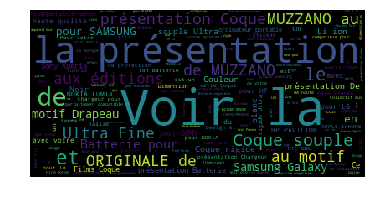

In [26]:
all_descr = " ".join(data_test.Description.values)
wordcloud_word = WordCloud(background_color="black").generate_from_text(all_descr)

plt.figure()
plt.imshow(wordcloud_word,cmap=plt.cm.Paired)
plt.axis("off")
plt.show()

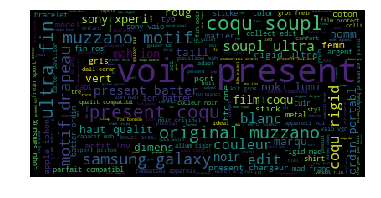

In [27]:
all_descr_clean_stem = " ".join(data_test_clean_stem.Description.values)
wordcloud_word = WordCloud(background_color="black").generate_from_text(all_descr_clean_stem)

plt.figure()
plt.imshow(wordcloud_word,cmap=plt.cm.Paired)
plt.axis("off")
plt.show()

Sauvegarder les jeux de données nettoyés avec et sans racinisation dans des fichiers csv.

In [28]:
data_test_clean.to_csv("data/cdiscount_test_clean.csv", index=False)
data_train_clean.to_csv("data/cdiscount_train_clean.csv", index=False)

data_test_clean_stem.to_csv("data/cdiscount_test_clean_stem.csv", index=False)
data_train_clean_stem.to_csv("data/cdiscount_train_clean_stem.csv", index=False)